# Estimating continuous model from discretised observations

We construct a discrete-time self-exciting process, which we hope will shed light on the bahaviours of continuous-time processes.

This model can be seen as a conditional non-negative linear regression (Kedem and Fokianos, 2002), or as a regression based on the "large cell" limit of the binned earthquake estimator of Saichev and Sornette (2006).

Many refinements are possibly; at this stage we are interested in the question of how well the *simplest possible* estimator performs to see if it is worth exploring further. If the preliminary study is promising, we can extend it by bootstrap bias correction, or analytic estimator improvments etc.

I have simulated 300 time series from the *continuous* Hawkes counting process $N_t$ for $t\in [0.0,1000.0]$, with apprximately 110000 events in each series.
I then sampled the values of this count time series at times $t\in(0,1,2,\dots,1000)$ to give a process $\{M_t\}_{t=(0,1,2,3\dots)}={N_t}$
.
I have fit a discrete self-exciting counting process regression to this *sampled* time series, and observe how the estimates of the parameters of this model inform us of the parameters of the true model.
For example, in each discretized "bin" of length 1, we witness not a Poisson *process*, but a single Poisson random variable, with expectation $$M_t-M_{t-1}\sim \text{Poisson}(\lambda_t)$$ where
$$\lambda_t = \bar{\mu} + \bar{\eta}\sum_{s\lt t}\bar{\psi}_\tau(t-s)M(t)$$.

Parameters of interest:

- $\eta$, the continuous-time branching ratio
- $\phi(t,\tau)$ the influence kernel parameterised by $\tau$, I take to be exponential, i.e.,  $\phi(t,\tau)=\tau^{-1}\mathbb{I}_{t>0}\exp t/\tau$
- $\mu$ the "background rate" is the endogenous process intensity.

We approximate these continuous-time parameters by the discretised paramets, e.g. $\bar{\eta}\simeq \eta$ the discrete-time branching ratio, and further approximate those parameters by their Maximum Likelihood estimates $\bar{\eta}\simeq \hat{\bar{\eta}}$... The question is, how informative are these? How many more correction terms as per Saichev and Sornette do we need to add?

## setup

In [1]:
import numpy as np
from importlib import reload
from scipy.stats import poisson, geom, expon
import pandas as pd
from src.util import saveobj, loadobj
from src import influence_discrete

In [2]:
# plotting requirements
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Large graphs by default
mpl.rcParams['figure.figsize'] = (10.0, 8.0)

## Ground-truth values

In [3]:
# The values used in the simulations

default_random_state = np.random.RandomState(1540)

end = 1000
real_tau = 40.0
real_kappa = 0.4
real_mu = 40.0
real_eta = 0.4
real_eta_prime = real_kappa/(1-real_eta)
immigrants = default_random_state.poisson(real_mu, size=end)
exp_phi = lambda t: expon(scale=real_tau).pdf(t)
phi_basis = influence_discrete.poisson_basis(start=0.5, spacing=2, max_m=10, clip_t=int(end*0.3))

## Load simulations

### First parse data from disk

In [4]:
#load lists of dicts of lists and process into DataFrame
def load_trimmed(path, model, tau):
    ests = loadobj(path)
    for d in ests:
        del d['phi']
        del d['weight']
    df = pd.DataFrame(ests)
    df['real_tau'] = float(tau)
    df['conditional'] = model
    df['mu_ratio'] = df['mu']/real_mu
    df['kappa_ratio'] = df['kappa']/real_eta_prime
    df['tau_ratio'] = df['tau']/df['real_tau']
    if 'eta' in df:
        df['eta_prime_ratio'] = df['kappa']/(1.0-df['eta'])/real_eta_prime
    else:
        df['eta_prime_ratio'] = df['kappa']/real_eta_prime
    return df

df = pd.concat([
    load_trimmed(path, model, tau) for path, model, tau in (
        ('poisson_fit__tau_01', 'poisson', 1.0),
        ('poisson_fit__tau_05', 'poisson', 5.0),
        ('poisson_fit__tau_40', 'poisson', 40.0),
        ('gpd_fit__tau_01', 'gpd', 1.0),
        ('gpd_fit__tau_05', 'gpd', 5.0),
        ('gpd_fit__tau_40', 'gpd', 40.0),
    )
])

## Plotted results

For now, I only try *two* alternative models, depending on the conditional distribution used in the discrete regression. where I have a Poisson conditional distribution (`poisson`), and an 'overdispersed' Generalised Poisson Distribution (`gpd`), where we may choose to interpret overdispersion as evidence of endogenous self-excitation.
Many other alternatives are available.

Intuitively, the longer the kernel (and the bigger $\tau$) the closer we expect the discretised model to be to the continuous time model, and the closer we hope our estimates to converge.

Therefore we also vary $\tau$, choosing a true value of $\tau\in\{1,5,40\}$.

For ease of visual comparison, I plot the *ratio* of estimated to true value.

### $\hat{\bar{\mu}}$, background rate estimate

As expected, for large $\tau$, the discretized estimate is quite good, although the Poisson marginal performs poorly as $\tau$ shrinks towards the bin size, the estimate is reasonably good for both conditional distributions.



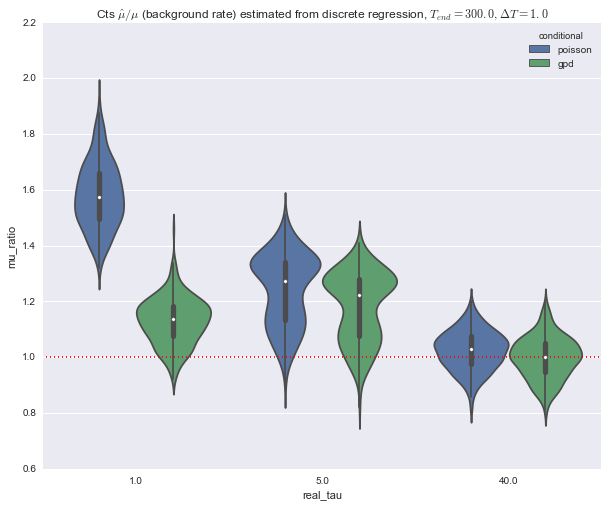

In [5]:
sns.violinplot(x='real_tau', y='mu_ratio', hue='conditional', data=df);
plt.title('Cts $\\hat{\\mu}/\\mu$ (background rate) estimated from discrete regression, ' 
          '$T_{end}=300.0, \\Delta T=1.0$');
plt.hlines(y=1.0, xmin=-1, xmax=3, linestyles=":", colors='red');

### $\hat{\bar{\tau}}$, influence kernel length

The quality of this estimator decreases much more rapidly with decreasing $\tau$ but performs well for larger values; conditional model makes little difference here.

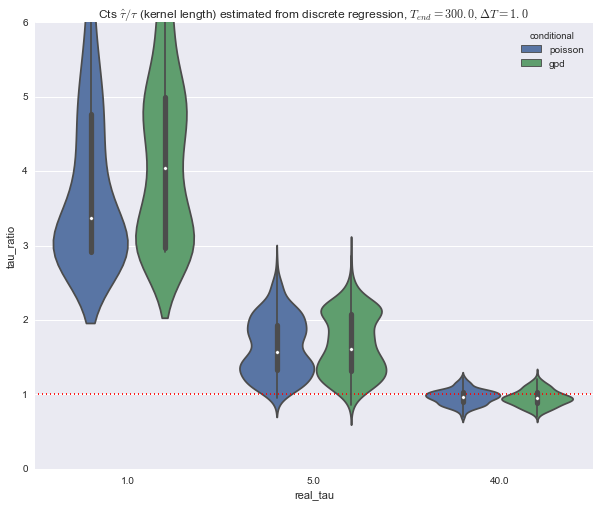

In [6]:
sns.violinplot(x='real_tau', y='tau_ratio', hue='conditional', data=df);
plt.title('Cts $\\hat{\\tau}/\\tau$ (kernel length) estimated from discrete regression, ' 
          '$T_{end}=300.0, \\Delta T=1.0$');
plt.hlines(y=1.0, xmin=-1, xmax=3, linestyles=":", colors='red');
plt.gca().set_ylim(0,6);

### $\hat{\bar{\eta}}$, uncorrected branching ratio estimate

We can interpret the $\eta$ directly as a branching ratio estimate;
we expect this to perform poorly with the Generalised Poisson conditional distribution, which will "absorb" some branching into the over-dispersion parameter.

Indeed, this is the case.

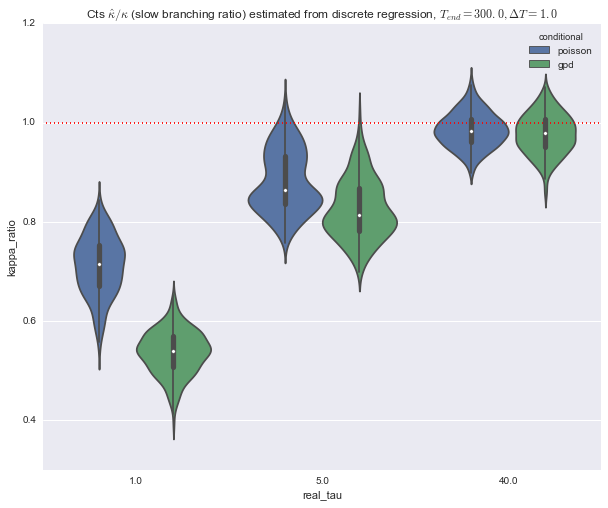

In [13]:
sns.violinplot(x='real_tau', y='kappa_ratio', hue='conditional', data=df);
plt.title('Cts $\\hat{\\kappa}/\\kappa$ (slow branching ratio) estimated from discrete regression, ' 
          '$T_{end}=300.0, \\Delta T=1.0$');
plt.hlines(y=1.0, xmin=-1, xmax=3, linestyles=":", colors='red');

### $\hat{\bar{\eta^*}}$, the "corrected" branching ratio estimate

For the Generalised Poisson distribution we can correct the branching ratio estimate by the over-dispersion parameters to see if this de-biases the estimate. Indeed it does, but the performance is not substantially better than for the poisson marginal.

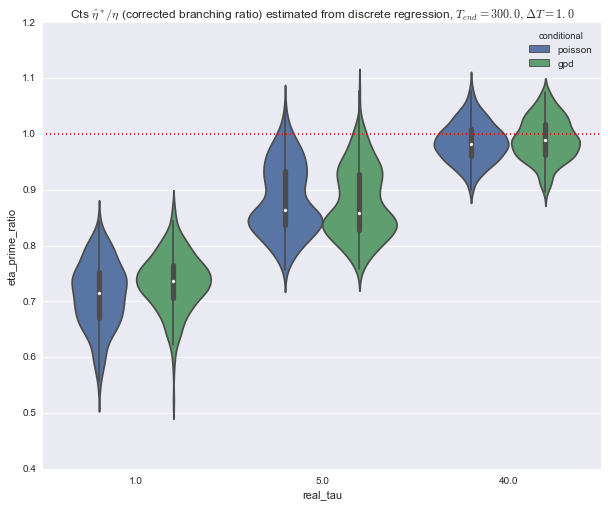

In [8]:
sns.violinplot(x='real_tau', y='eta_prime_ratio', hue='conditional', data=df);
plt.title('Cts $\\hat{\\eta}^*/\\eta$ (corrected branching ratio) estimated from discrete regression, ' 
          '$T_{end}=300.0, \\Delta T=1.0$');
plt.hlines(y=1.0, xmin=-1, xmax=3, linestyles=":", colors='red');

## Performance issues

Whilst this estimator is not yet spectacular in accuracy, it is worth considering the performance tradeoff for such an estimate.

How long was the median time taken to fit each model, typically?


In [11]:
print(df['time'].median(), 'seconds')

1.724312424659729 seconds


How many events were in each time series typically?

In [12]:
print(df['n'].median(), 'events')

118541.0 events
